## Modelling and Training Notebook

### Imports

In [0]:
import pickle
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import torch
import torch.nn.functional as F
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.utils import check_array

import config as cfg

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
def load_ds(ds_filename):
    with open(ds_filename, "rb") as f:
        return pickle.load(f)

Custom metrics function for MAPE and Theil-U

In [0]:
def mean_absolute_percentage_error(y_true, y_pred):
    
    return np.mean(np.abs(np.array(y_true) - np.array(y_pred)) / np.array(y_true))

def theil_u(y_true, y_pred):
    
    den = np.sqrt(np.mean(np.array(y_true)**2)) + np.sqrt(np.mean(np.array(y_pred)**2)) 
    
    return mean_squared_error(y_true, y_pred) / den

Transform pandas dataframe into dataloader for training

In [0]:
def df_to_dataloader(ds, targetcol_name="Target"):
    tmpdf_train = ds['train'].copy()
    tmpdf_val = ds['val'].copy()
    tmpdf_test = ds['test'].copy()
    target_train = tmpdf_train[targetcol_name]
    target_val = tmpdf_val[targetcol_name]
    target_test = tmpdf_test[targetcol_name]
    del tmpdf_train[targetcol_name]
    del tmpdf_val[targetcol_name]
    del tmpdf_test[targetcol_name]
    del tmpdf_train["Date"]
    del tmpdf_val["Date"]
    del tmpdf_test["Date"]

    mu, sigma = tmpdf_train['Close'].mean(), tmpdf_train["Close"].std()

    target_train = (target_train-mu)/sigma
    target_val = (target_val-mu)/sigma
    target_test = (target_test-mu)/sigma

    tmpdf_train=(tmpdf_train-mu)/sigma
    tmpdf_val=(tmpdf_val-mu)/sigma
    tmpdf_test=(tmpdf_test-mu)/sigma
    
    print(tmpdf_train.describe())

    trainds = torch.utils.data.TensorDataset(torch.Tensor(np.array(tmpdf_train)), torch.Tensor(np.array(target_train)))
    trainloader = torch.utils.data.DataLoader(trainds, batch_size=50, shuffle=False)
    valds = torch.utils.data.TensorDataset(torch.Tensor(np.array(tmpdf_val)), torch.Tensor(np.array(target_val)))
    valloader = torch.utils.data.DataLoader(valds, batch_size=20, shuffle=False)
    testds = torch.utils.data.TensorDataset(torch.Tensor(np.array(tmpdf_test)), torch.Tensor(np.array(target_test)))
    testloader = torch.utils.data.DataLoader(testds, batch_size=20, shuffle=False)
    return trainloader, valloader, testloader

In [0]:
SPY_ds = load_ds("SPY_ds.pkl")

In [182]:
SPY_ds["MLP"]["train"]

,Date,Close,Close_Lag1,Close_Lag3,Close_Lag5,Close_Lag7,Close_Lag8,Close_Lag9,Close_Lag12,Target
0,2011-01-03,127.050003,125.750000,125.919998,125.650002,125.779999,125.389999,124.599998,124.099998,126.980003
1,2011-01-04,126.980003,127.050003,125.720001,125.830002,125.599998,125.779999,125.389999,124.820000,127.639999
2,2011-01-05,127.639999,126.980003,125.750000,125.919998,125.650002,125.599998,125.779999,124.300003,127.389999
3,2011-01-06,127.389999,127.639999,127.050003,125.720001,125.830002,125.650002,125.599998,124.599998,127.139999
4,2011-01-07,127.139999,127.389999,126.980003,125.750000,125.919998,125.830002,125.650002,125.389999,126.980003
...,...,...,...,...,...,...,...,...,...,...
497,2012-12-24,142.350006,142.789993,144.289993,143.770004,142.630005,143.509995,143.440002,141.979996,141.750000
498,2012-12-26,141.750000,142.350006,145.119995,145.369995,142.100006,142.630005,143.509995,142.410004,141.559998
499,2012-12-27,141.559998,141.750000,142.789993,144.289993,143.770004,142.100006,142.630005,142.470001,140.029999
500,2012-12-28,140.029999,141.559998,142.350006,145.119995,145.369995,143.770004,142.100006,143.440002,142.410004


In [183]:
trainloader_SPY_MLP, valloader_SPY_MLP, testloader_SPY_MLP = df_to_dataloader(SPY_ds["MLP"])

              Close  Close_Lag1  ...  Close_Lag9  Close_Lag12
count  5.020000e+02  502.000000  ...  502.000000   502.000000
mean  -9.030846e-15   -0.004218  ...   -0.039355    -0.053352
std    1.000000e+00    0.999151  ...    0.990273     0.987608
min   -2.870960e+00   -2.870960  ...   -2.870960    -2.870960
25%   -5.792061e-01   -0.587469  ...   -0.617975    -0.644349
50%    6.840786e-02    0.062052  ...    0.018835     0.007397
75%    7.296865e-01    0.723013  ...    0.656282     0.641982
max    1.871433e+00    1.871433  ...    1.871433     1.871433

[8 rows x 8 columns]


In [0]:
class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.hidden = torch.nn.Linear(self.input_size, self.hidden_size)
        self.out = torch.nn.Linear(self.hidden_size, self.output_size)
    
    def forward(self, x):
        x = torch.sigmoid(self.hidden(x))
        x = self.out(x)
        
        return x

In [0]:
def init_normal(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.normal_(m.weight, mean=0, std=1)
"""
SPY_MLP = MLP(cfg.train_parameters['SPY']['MLP']['input_size']+1,
              cfg.train_parameters['SPY']['MLP']['hidden_size'],
              cfg.train_parameters['SPY']['MLP']['output_size']
             )
"""

SPY_MLP = torch.nn.Sequential(
    torch.nn.Linear(cfg.train_parameters['SPY']['MLP']['input_size']+1,
                    cfg.train_parameters['SPY']['MLP']['hidden_size']),
    torch.nn.ReLU(),
    torch.nn.Linear(cfg.train_parameters['SPY']['MLP']['hidden_size'],
                    cfg.train_parameters['SPY']['MLP']['output_size'])
)
SPY_MLP.apply(init_normal)
SPY_MLP.to(device)

if cfg.train_parameters["SPY"]["MLP"]["optim"] == "SGD":
    SPY_MLP_optimizer = torch.optim.SGD(SPY_MLP.parameters(),
                                        lr = cfg.train_parameters["SPY"]["MLP"]["lr"],
                                        momentum = cfg.train_parameters["SPY"]["MLP"]["momentum"]
                                       )
else:
    SPY_MLP_optimizer = torch.optim.Adam(SPY_MLP.parameters(),
                                        lr = cfg.train_parameters["SPY"]["MLP"]["lr"],
                                        momentum = cfg.train_parameters["SPY"]["MLP"]["momentum"]
                                        )

loss_fn = torch.nn.MSELoss()

In [0]:
from tqdm.notebook import tqdm as tq

In [225]:
train_losses, val_losses = [], []

for epoch in tq(range(cfg.train_parameters["SPY"]["MLP"]["epochs"]), desc="Training"):
    SPY_MLP.train()
    
    train_loss, val_loss = [], []
    
    for features, target in trainloader_SPY_MLP:
        SPY_MLP_optimizer.zero_grad()
        
        outputs = SPY_MLP(features.to(device))
        loss = loss_fn(outputs, target.view(-1,1).to(device))
        loss.backward()
        SPY_MLP_optimizer.step()
        
        train_loss.append(loss.item())
    
    SPY_MLP.eval()
    with torch.no_grad():
        for features, target in valloader_SPY_MLP:
            outputs = SPY_MLP(features.to(device))
            loss = loss_fn(outputs, target.to(device))
            
            val_loss.append(loss.item())
    
    train_losses.append(np.mean(train_loss))
    val_losses.append(np.mean(val_loss))
    
    if (epoch+1) % 1000 == 0 or epoch+1 == 1:
        print("Epoch {}/{} - Train Loss : {:.4f} / Val Loss : {:.4f}".format(epoch + 1,
                                                                             cfg.train_parameters["SPY"]["MLP"]["epochs"],
                                                                             np.mean(train_loss),
                                                                             np.mean(val_loss)))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/30000 - Train Loss : 2.7723 / Val Loss : 3.0739
Epoch 1000/30000 - Train Loss : 0.0447 / Val Loss : 0.1504
Epoch 2000/30000 - Train Loss : 0.0399 / Val Loss : 0.1489
Epoch 3000/30000 - Train Loss : 0.0385 / Val Loss : 0.1501
Epoch 4000/30000 - Train Loss : 0.0377 / Val Loss : 0.1515
Epoch 5000/30000 - Train Loss : 0.0372 / Val Loss : 0.1548
Epoch 6000/30000 - Train Loss : 0.0369 / Val Loss : 0.1561
Epoch 7000/30000 - Train Loss : 0.0365 / Val Loss : 0.1570
Epoch 8000/30000 - Train Loss : 0.0363 / Val Loss : 0.1571
Epoch 9000/30000 - Train Loss : 0.0361 / Val Loss : 0.1578
Epoch 10000/30000 - Train Loss : 0.0360 / Val Loss : 0.1583



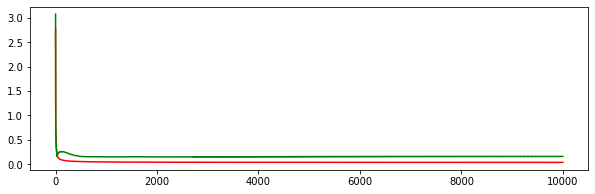

In [226]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,3))
plt.plot(train_losses, color="r")
plt.plot(val_losses, color="g");

In [0]:
train_preds, train_targets = [], []
val_preds, val_targets = [], []
test_preds, test_targets = [], []

SPY_MLP.eval()
with torch.no_grad():
    for features, target in trainloader_SPY_MLP:
        outputs = SPY_MLP(features.to(device))
        train_preds += outputs.cpu().numpy().T.tolist()[0]
        train_targets += target.numpy().tolist()
    for features, target in valloader_SPY_MLP:
        outputs = SPY_MLP(features.to(device))
        val_preds += outputs.cpu().numpy().T.tolist()[0]
        val_targets += target.numpy().tolist()
    for features, target in testloader_SPY_MLP:
        outputs = SPY_MLP(features.to(device))
        test_preds += outputs.cpu().numpy().T.tolist()[0]
        test_targets += target.numpy().tolist()

In [228]:
print("Training Set")
print("RMSE : ", mean_squared_error(train_targets, train_preds))
print("MAE : ", mean_absolute_error(train_targets, train_preds))
print("MAPE : ", mean_absolute_percentage_error(train_targets, train_preds))
print("Theil-U :", theil_u(train_targets, train_preds))
print("")
print("Validation Set")
print("RMSE : ", mean_squared_error(val_targets, val_preds))
print("MAE : ", mean_absolute_error(val_targets, val_preds))
print("MAPE : ", mean_absolute_percentage_error(val_targets, val_preds))
print("Theil-U :", theil_u(val_targets, val_preds))
print("")
print("Test Set")
print("RMSE : ", mean_squared_error(test_targets, test_preds))
print("MAE : ", mean_absolute_error(test_targets, test_preds))
print("MAPE : ", mean_absolute_percentage_error(test_targets, test_preds))
print("Theil-U :", theil_u(test_targets, test_preds))

Training Set
RMSE :  0.03766923613021228
MAE :  0.1434144272987983
MAPE :  0.005727397988808101
Theil-U : 0.018818803722122017

Validation Set
RMSE :  0.06976694470492395
MAE :  0.2082852115706792
MAPE :  0.051138095303087445
Theil-U : 0.00831642805236113

Test Set
RMSE :  0.35967500665517627
MAE :  0.5244200445038507
MAPE :  0.06347969736763091
Theil-U : 0.022717542588090826


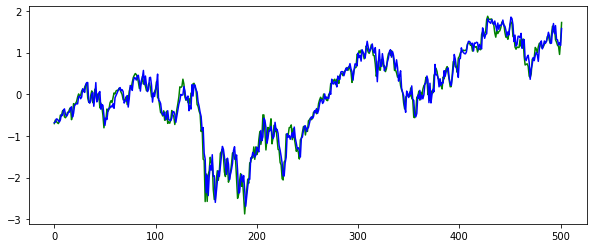

In [229]:
plt.figure(figsize=(10,4))
plt.plot(train_targets, color="g")
plt.plot(train_preds, color="b");

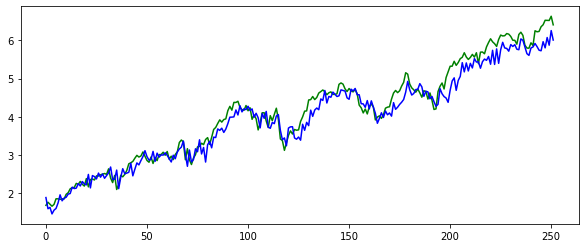

In [230]:
plt.figure(figsize=(10,4))
plt.plot(val_targets, color="g")
plt.plot(val_preds, color="b");

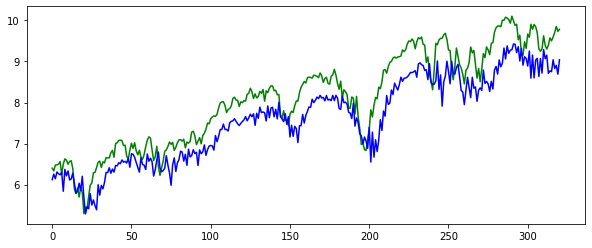

In [231]:
plt.figure(figsize=(10,4))
plt.plot(test_targets, color="g")
plt.plot(test_preds, color="b");